# "Fine tuning" google's yamnet network to detect train sounds 

Accompanies the blog post here: 

This was a weekend project to track / quantify the train in my neighborhood that honks a lot. 
I eventually plan to correlate with my sleep patterns, but that's another day. 

As this was a short weekend project, no care has been take around clean code / bugs / proper validation dataset, etc.

### Some background
Google released yamnet: see https://github.com/tensorflow/models/tree/master/research/audioset/yamnet 
"YAMNet is a pretrained deep net that predicts 521 audio event classes based on the AudioSet-YouTube corpus, and employing the Mobilenet_v1 depthwise-separable convolution architecture."

The yamnet model does contain a 'train' and 'train horn' class, but found it was not accurate enough on my data. If your data is one of the 521 classes, you might be able to directly use the yamnet output and not train anything. 


This notebook takes the output feature vectors from yamnet as 1024 length vectors per patch of audio. We then feed those vectors into a small network that has been trained on the data I care about ( "train horn" vs "not train horn" ) 

I created a very small dataset of about 10 wavs per class -- where the "not train horn" class is just background noise, or noises that might be confused with a train horn ( dog bark, etc ) Each training sound is augmented a few times to create more data. 

Note: I did remove a few files from the data included here for file size reasons, but only 1-2 wav files. The accuracy here will be slightly lower than what I got. You can experiment with how much data is required for your task. 


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os 
import random
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [3]:
# sound libs, you don't really need all of them 
# librosa should suffice 
import soundfile as sf
import librosa
import resampy

## Clone the tf models repo 

 * NOTE: Large ~1GB download 

In [5]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


### Download the pre-trained weights for yamnet model

In [6]:
!wget https://storage.googleapis.com/audioset/yamnet.h5

--2020-03-09 16:50:46--  https://storage.googleapis.com/audioset/yamnet.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.18.208, 2a00:1450:4007:805::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.18.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15296092 (15M) [application/octet-stream]
Saving to: ‘yamnet.h5.1’

yamnet.h5.1         100%[===================>]  14,59M  9,31MB/s    in 1,6s    

2020-03-09 16:50:49 (9,31 MB/s) - ‘yamnet.h5.1’ saved [15296092/15296092]



In [5]:
## Yamnet imports 
import params
import yamnet as yamnet_tf
import modified_yamnet as yamnet


import features as features_lib

In [6]:
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [11]:
print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)

tf version:  2.0.0
tf.keras version:  2.2.4-tf


In [7]:
# OPTION 1
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# OPTION 2
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
DESIRED_SR = 16000
NUM_CLASSES = 2 # (plane, no plane)

# Set up the YAMNet model.
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.

yamnet_model, dense_net = yamnet.yamnet_frames_model(params)

yamnet_model.load_weights('yamnet.h5')

class_names = yamnet_tf.class_names(os.path.join(yamnet_base, 'yamnet_class_map.csv'))

## Some helper functions for later

In [9]:
def read_wav(fname, output_sr, use_rosa=True):
    # small wrapper - i was seeing some slightly different 
    # results when loading with different libraries 
    if use_rosa:
        waveform, sr = librosa.load(fname, sr=output_sr)
    else:
        wav_data, sr = sf.read(fname, dtype=np.int16)
        
        if wav_data.ndim > 1: 
            # (ns, 2)
            wav_data = wav_data.mean(1)
        if sr != output_sr:
            wav_data = resampy.resample(wav_data, sr, output_sr)
        waveform = wav_data / 32768.0
    
    return waveform.astype(np.float64)


In [10]:
def remove_silence(waveform, top_db=15, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves


In [11]:
def get_top_dirs(p):
    dirs = list(filter(lambda x : os.path.isdir( os.path.join(p, x) ), os.listdir(p)))
    return list(map(lambda x : os.path.join(p, x), dirs))

In [12]:
def random_augment_wav(wav_data):
    # apply some random augmentations to the sound
    # - time stretch, resample, volume change, minor noise 
    # - this has not been evaluated to measure contributions
    # - TODO: probably a lot more augmentations you could use 
    
    wav_data = wav_data.copy() 
    
    # random re-sample 
    if np.random.uniform() > 0.8:
        stretch = np.random.uniform(0.75, 1.5)
        wav_data = librosa.effects.time_stretch(wav_data, stretch)
    elif np.random.uniform() > 0.2:
        new_sr = int(DESIRED_SR * np.random.uniform(0.9, 1.1))
        wav_data = resampy.resample(wav_data, DESIRED_SR, new_sr)
    
    #librosa.effects.pitch_shift()
    
    # random volume
    volume = np.random.uniform(0.65, 1.2)
    wav_data = wav_data * volume
    
    # Random noise
    if np.random.uniform() > 0.5:
        NR = 0.001 # 0.1
        wav_data += np.random.uniform(-NR, NR, size=wav_data.shape)
    
    return wav_data
    
    

In [13]:
def load_data(base_path, 
              audio_model, 
              num_augmentations=5,
              max_sample_seconds=5.0,
              use_rosa=True):
    """
    Loads data from .wav files contained in subfolders where 
    folder name is label, then runs them 
    through the audio_model to get feature vectors 
    and returns:
    
    X : [ np.array(1024) , ... ]
    Y : [ category_idx , ...]
    
    """
    
    label_dirs = get_top_dirs(base_path)
    
    _samples = []
    _labels = []
    
    merge_chunks = True
    MIN_WAV_SIZE = 5000 # TODO: seems to need to be pretty long for NN to work?
    max_wav_size = int(DESIRED_SR * max_sample_seconds)
    
    for label_idx, label_dir in enumerate(label_dirs):
        
        label_name = os.path.basename(label_dir)
        wavs = glob.glob(os.path.join(label_dir, "*.wav"))
        print(" Loading {:<5} '{:<40}'".format(label_idx, label_name))
        
        for wav_file in tqdm(wavs):
            
            # rosa seems very different?
            #for use_rosa in range(2):
            if True:
                #use_rosa = 1
                #use_rosa = np.random.uniform() > 0.5
                waveform = read_wav(wav_file, DESIRED_SR, use_rosa=use_rosa)

                if label_name == 'train':
                    waveform = remove_silence(waveform)

                if len(waveform) < MIN_WAV_SIZE:
                    continue 

                if len(waveform) > max_wav_size:
                    waveform = waveform[:max_wav_size]
                    print("\nIgnoring audio data after {} seconds".format(max_sample_seconds))

                for aug_idx in range(1 + num_augmentations):
                    
                    aug_wav = waveform.copy()
                    
                    if aug_idx > 0:
                        aug_wav = random_augment_wav(aug_wav)

                    _, _, dense_out, _ = audio_model.predict(np.reshape(aug_wav, [1, -1]), steps=1)
                    
                    for patch in dense_out:
                        _samples.append(patch)
                        _labels.append(label_idx)
                
    return _samples, _labels
    

dtype('float16')

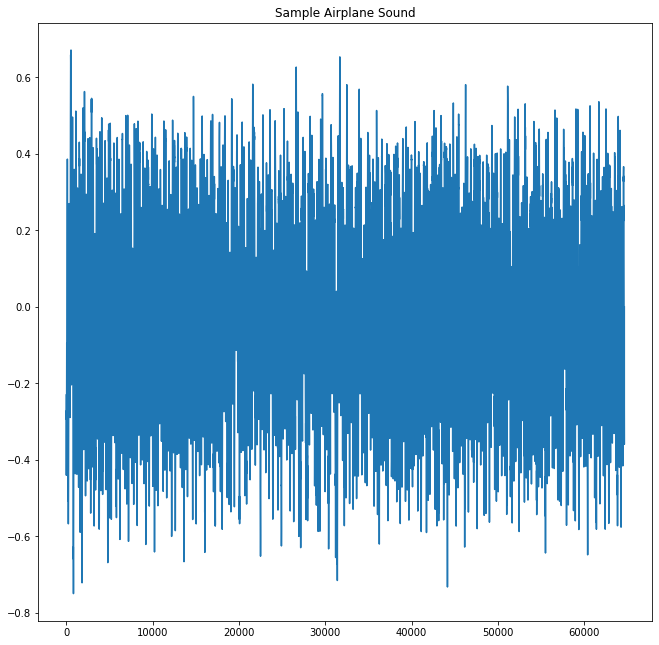

In [14]:
## Plot a wave file 

fname = "training_data_planes/plane/track_04_0000_norm.wav"

waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

figure(figsize=(11,11))

plot(waveform)
title("Sample Airplane Sound")

waveform = waveform.astype(np.float16)
waveform.dtype

### Plot Yamnet predictions on our data

In [15]:
# Run the model.
scores, spectrogram, dense_out, patches = yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)

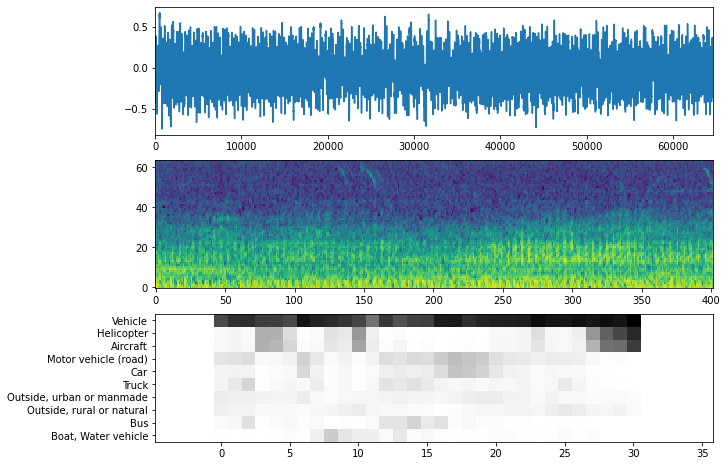

In [20]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

In [ ]:
## Load our training data

In [18]:
samples, labels = load_data("training_data_planes",
                            yamnet_model,
                            num_augmentations=8, 
                            max_sample_seconds=5.0)




  0%|          | 0/14 [00:00<?, ?it/s]

 Loading 0     'plane                                   '


  0%|          | 0/16 [00:00<?, ?it/s]

 Loading 1     'not_plane                               '


100%|██████████| 16/16 [02:37<00:00,  9.81s/it]


In [21]:
len(samples)

7135

In [22]:
idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


 Loaded samples:  (7135, 1024) float32 (7135,)


## Create our 'fine tuning' thin model that accepts yamnet feature vector outputs 

You can play with how many layers, or which activation functions to use, etc

In [15]:
def get_top_model(num_classes=3, 
                  input_size=1024,
                  num_hidden=1024):

    input_layer = layers.Input(shape=(input_size,))
    
    output = layers.Dense(num_hidden, activation=None)(input_layer)
    
    output = layers.Dense(num_classes, activation='softmax')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [23]:
num_hidden = 1024
feature_len = 1024

model = get_top_model(num_classes=NUM_CLASSES, 
                      input_size=feature_len, 
                      num_hidden=num_hidden)

#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
# Train the model 
history = model.fit(samples, labels, epochs=200, validation_split=0.1)

Train on 6421 samples, validate on 714 samples
Epoch 1/200
6421/6421 [==============================] - 7s 1ms/sample - loss: 0.1163 - accuracy: 0.9785 - val_loss: 0.0395 - val_accuracy: 0.9972
Epoch 2/200
6421/6421 [==============================] - 3s 498us/sample - loss: 0.0304 - accuracy: 0.9963 - val_loss: 0.0249 - val_accuracy: 0.9986
Epoch 3/200
6421/6421 [==============================] - 3s 505us/sample - loss: 0.0206 - accuracy: 0.9972 - val_loss: 0.0184 - val_accuracy: 0.9986
Epoch 4/200
6421/6421 [==============================] - 3s 497us/sample - loss: 0.0160 - accuracy: 0.9978 - val_loss: 0.0147 - val_accuracy: 0.9986
Epoch 5/200
6421/6421 [==============================] - 3s 507us/sample - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.0127 - val_accuracy: 0.9986
Epoch 6/200
6421/6421 [==============================] - 3s 476us/sample - loss: 0.0115 - accuracy: 0.9981 - val_loss: 0.0111 - val_accuracy: 0.9986
Epoch 7/200
6421/6421 [==============================] - 3s 4

6421/6421 [==============================] - 3s 506us/sample - loss: 9.5979e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 110/200
6421/6421 [==============================] - 3s 479us/sample - loss: 9.5217e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 111/200
6421/6421 [==============================] - 3s 499us/sample - loss: 9.4375e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 112/200
6421/6421 [==============================] - 3s 485us/sample - loss: 9.3547e-04 - accuracy: 1.0000 - val_loss: 9.9630e-04 - val_accuracy: 1.0000
Epoch 113/200
6421/6421 [==============================] - 3s 484us/sample - loss: 9.2740e-04 - accuracy: 1.0000 - val_loss: 9.8877e-04 - val_accuracy: 1.0000
Epoch 114/200
6421/6421 [==============================] - 3s 481us/sample - loss: 9.1947e-04 - accuracy: 1.0000 - val_loss: 9.8049e-04 - val_accuracy: 1.0000
Epoch 115/200
6421/6421 [==============================] - 3s 481us/samp

Epoch 161/200
6421/6421 [==============================] - 3s 481us/sample - loss: 6.4166e-04 - accuracy: 1.0000 - val_loss: 7.2132e-04 - val_accuracy: 1.0000
Epoch 162/200
6421/6421 [==============================] - 3s 490us/sample - loss: 6.3603e-04 - accuracy: 1.0000 - val_loss: 7.1640e-04 - val_accuracy: 1.0000
Epoch 163/200
6421/6421 [==============================] - 3s 475us/sample - loss: 6.3250e-04 - accuracy: 1.0000 - val_loss: 7.1260e-04 - val_accuracy: 1.0000
Epoch 164/200
6421/6421 [==============================] - 3s 528us/sample - loss: 6.2847e-04 - accuracy: 1.0000 - val_loss: 7.0882e-04 - val_accuracy: 1.0000
Epoch 165/200
6421/6421 [==============================] - 3s 522us/sample - loss: 6.2378e-04 - accuracy: 1.0000 - val_loss: 7.0487e-04 - val_accuracy: 1.0000
Epoch 166/200
6421/6421 [==============================] - 3s 489us/sample - loss: 6.1995e-04 - accuracy: 1.0000 - val_loss: 7.0124e-04 - val_accuracy: 1.0000
Epoch 167/200
6421/6421 [=====================

In [26]:
# a few iterations on all the data
history = model.fit(samples, labels, epochs=5)

Train on 4043 samples
Epoch 1/5
4043/4043 [==============================] - 1s 348us/sample - loss: 6.1365e-04 - accuracy: 1.0000
Epoch 2/5
4043/4043 [==============================] - 1s 346us/sample - loss: 6.0907e-04 - accuracy: 1.0000
Epoch 3/5
4043/4043 [==============================] - 1s 338us/sample - loss: 6.0518e-04 - accuracy: 1.0000
Epoch 4/5
4043/4043 [==============================] - 1s 351us/sample - loss: 6.0124e-04 - accuracy: 1.0000
Epoch 5/5
4043/4043 [==============================] - 1s 345us/sample - loss: 5.9747e-04 - accuracy: 1.0000


## Test on a holdout sound 

In [16]:
# Load model
from tensorflow.keras.models import load_model

model_new = load_model('top_model.h5')

#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_new.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________


In [17]:
def run_models(waveform, 
               yamnet_model, 
               top_model, 
               strip_silence=True, 
               min_samples=16000):
    
    if strip_silence:
        waveform = remove_silence(waveform, top_db=10)
    
    if len(waveform) < min_samples:
        print("input too short after silence removal")
        return [-1] #this value will be used to discard unfit audios later
    
    _, _, dense_out, _ = \
        yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)
    
    # dense = (N, 1024)
    all_scores = []
    for patch in dense_out:
        scores = top_model.predict( np.expand_dims(patch,0)).squeeze()
        all_scores.append(scores)
        
    all_scores = np.mean(all_scores, axis=0)
    return all_scores


In [18]:
# categories = ["not train", "train"]

categories = ["plane", "not plane"]

In [19]:
fname = "holdout_plane_sounds/244330__vumseplutten1709__enginetuning10000_norm.wav"
waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

#waveform = remove_silence(waveform, top_db=10)


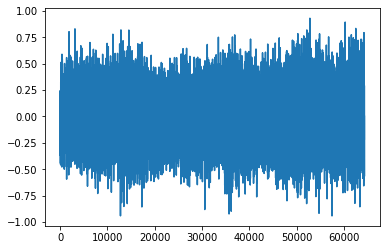

In [20]:
plot(waveform)

In [21]:
# scores = run_models(waveform, yamnet_model, model)
scores = run_models(waveform, yamnet_model, model_new)
winner = categories[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))


 Best score: 0.940509557723999  label: plane


In [24]:
# import os
# holdout_dir = "holdout_plane_sounds"
# arr = os.listdir(holdout_dir)

from glob import glob
holdout_dir = 'holdout_noise_sounds/'
holdout_wav = [f for f in glob(holdout_dir+"*.wav")]

min_sample_seconds = 0.9

for fname in holdout_wav: 
    waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

    # waveform = remove_silence(waveform, top_db=10)
    
    # make file a bit longer by duplicating it
    if len(waveform) < DESIRED_SR*min_sample_seconds:
        continue
#         waveform = np.concatenate((waveform,waveform,waveform,waveform))

    scores = run_models(waveform, yamnet_model, model_new, strip_silence=False)
    
    if scores[0] != -1:
        winner = categories[scores.argmax()]
        print("File:",os.path.basename(fname))
        print(" Best score: {}  label: {}".format(scores.max(), winner))

File: 103074-7-0-0.wav
 Best score: 0.9993352293968201  label: not plane
File: 103199-4-0-0.wav
 Best score: 0.6846156120300293  label: not plane
File: 102305-6-0-0.wav
 Best score: 0.9844768643379211  label: not plane
File: 100263-2-0-117.wav
 Best score: 0.9765697121620178  label: not plane
File: 102853-8-0-0.wav
 Best score: 0.8453531861305237  label: plane
File: 101848-9-0-0.wav
 Best score: 0.9964523911476135  label: not plane
File: 100852-0-0-0.wav
 Best score: 0.6016215085983276  label: not plane
File: 102857-5-0-0.wav
 Best score: 0.9959386587142944  label: not plane


In [33]:
## Save the model for later
model.save("top_model.h5", include_optimizer=False)

In [36]:
# NOTE: PyAudio required here 
# device index from pyaudio 
!python3 classify_from_mic.py 0


2020-03-09 18:00:08.257318: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
 --- Using input device:  0
2020-03-09 18:00:19.234401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-09 18:00:19.258650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:973] ARM64 does not support NUMA - returning NUMA node zero
2020-03-09 18:00:19.258959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA Tegra X2 major: 6 minor: 2 memoryClockRate(GHz): 1.3
pciBusID: 0000:00:00.0
2020-03-09 18:00:19.259074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-03-09 18:00:19.264005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-09 18:00:19.268327: I tensorflow/st

{'index': 0, 'structVersion': 2, 'name': 'tegra-hda: HDMI 0 (hw:0,3)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 8, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
_______
{'index': 1, 'structVersion': 2, 'name': 'tegra-hda: HDMI 0 (hw:0,7)', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': -1.0, 'defaultLowOutputLatency': 0.005804988662131519, 'defaultHighInputLatency': -1.0, 'defaultHighOutputLatency': 0.034829931972789115, 'defaultSampleRate': 44100.0}
_______
{'index': 2, 'structVersion': 2, 'name': 'tegra-snd-t186ref-mobile-rt565x: - (hw:1,0)', 'hostApi': 0, 'maxInputChannels': 16, 'maxOutputChannels': 16, 'defaultLowInputLatency': 0.008707482993197279, 'defaultLowOutputLatency': 0.008707482993197279, 'defaultHighInputLatency': 0.034829931972789115, 'defaultHighOutputLatency': 0.03482

ALSA lib confmisc.c:1281:(snd_func_refer) Unable to find definition 'cards.tegra-hda.pcm.front.0:CARD=0'
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5007:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM front
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2495:(snd_pcm_open_no